<a href="https://colab.research.google.com/github/ryan-avancena/1st/blob/main/481_mcdonalds_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll be building a sentiment analysis model from McDonald's Store Reviews!

---

**About the dataset**

This dataset contains over 33,000 anonymized reviews of McDonald's stores in the United States, scraped from Google reviews. It provides valuable insights into customer experiences and opinions about various McDonald's locations across the country. The dataset includes information such as store names, categories, addresses, geographic coordinates, review ratings, review texts, and timestamps.

It's worth noting that the data is collected from 12 US States:
* California
* Washington D.C
* Florida
* Illinois
* New Jersey
* Nevada
* New York
* Pennsylvania
* Texas
* Utah
* Virginia
* Hawaii

Link to Dataset: https://www.kaggle.com/datasets/nelgiriyewithana/mcdonalds-store-reviews

# Part I. Building the Model

Building a Naive Bayes Classifier to identify positive and negative sentiments.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import chardet

# Read the first few bytes to detect the encoding
# with open('mcdonalds_reviews.csv', 'rb') as file:
#     result = chardet.detect(file.read(10000))
#     print(result)

mcd_reviews = pd.read_csv('mcdonalds_reviews.csv',encoding='ISO-8859-1')
# mcd_reviews.isna().sum()

In [ ]:
cleaned_mcd_reviews = mcd_reviews[['review','rating']]
cleaned_mcd_reviews['rating'].value_counts()
# mcd_reviews.head()

,count
rating,
5 stars,10274
1 star,9431
4 stars,5787
3 stars,4818
2 stars,3086


given that we have almost a 50/50 distribution between positive and negative reviews, i will focus on those only

* 4 + 5 star = 16,061 total reviews
* 1 + 2 star = 12,517 total reviews

In [ ]:
# Focusing on 1, 2, 4, and 5 star reviews
cleaned_mcd_reviews = cleaned_mcd_reviews[
    (cleaned_mcd_reviews['rating'] == '1 star') |
    (cleaned_mcd_reviews['rating'] == '2 stars') |
    (cleaned_mcd_reviews['rating'] == '4 stars') |
    (cleaned_mcd_reviews['rating'] == '5 stars')
]

cleaned_mcd_reviews.replace({'5 stars': 'positive', '1 star': 'negative',
                              '2 stars': 'negative', '4 stars': 'positive'}, inplace=True)


cleaned_mcd_reviews.columns = ['text', 'sentiment']

In [ ]:
cleaned_mcd_reviews['sentiment'].value_counts()

,count
sentiment,
positive,16061
negative,12517


---

In [ ]:
cleaned_mcd_reviews.head()

,text,sentiment
0,Why does it look like someone spit on my food?...,negative
1,It'd McDonalds. It is what it is as far as the...,positive
2,Made a mobile order got to the speaker and che...,negative
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,positive
4,"I repeat my order 3 times in the drive thru, a...",negative


In [ ]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# let's process the text
stop_words = set(nltk.corpus.stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

def preprocess_text(text):
  text = re.sub(r'[^\x00-\x7F]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  words = text.split()
  words = [word for word in words if word not in stop_words]
  # words = [porter.stem(word) for word in words]
  words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(words)

cleaned_mcd_reviews['cleaned_text'] = (
    cleaned_mcd_reviews['text']
    .str.lower()
    .str.replace(f"[{string.punctuation}]", "", regex=True)
    .apply(preprocess_text)
)

In [ ]:
cleaned_mcd_reviews.head()

,text,sentiment,cleaned_text
0,Why does it look like someone spit on my food?...,negative,look like someone spit food normal transaction...
1,It'd McDonalds. It is what it is as far as the...,positive,itd mcdonalds far food atmosphere go staff mak...
2,Made a mobile order got to the speaker and che...,negative,made mobile order got speaker checked line mov...
3,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,positive,mc crispy chicken sandwich customer service qu...
4,"I repeat my order 3 times in the drive thru, a...",negative,repeat order 3 time drive thru still manage me...


In [ ]:
# word clouds
negative = cleaned_mcd_reviews[cleaned_mcd_reviews['sentiment'] == 'negative']
positive = cleaned_mcd_reviews[cleaned_mcd_reviews['sentiment'] == 'positive']

import matplotlib.pyplot as plt
from wordcloud import WordCloud

cloud = WordCloud()

counts_neg = (
    negative['cleaned_text']
    .str.replace(f"[{string.punctuation}]", "", regex=True)
    .str.split()
    .apply(lambda words: [word for word in words if len(word) > 1])
    .explode()
    .value_counts()
)

counts_pos = (
    positive['cleaned_text']
    .str.replace(f"[{string.punctuation}]", "", regex=True)
    .str.split()
    .apply(lambda words: [word for word in words if len(word) > 1])
    .explode()
    .value_counts()
)

# counts_neg
# counts_pos

counts_pos_dict = dict(zip(counts_pos.index, counts_pos.values))
counts_neg_dict = dict(zip(counts_neg.index, counts_neg.values))

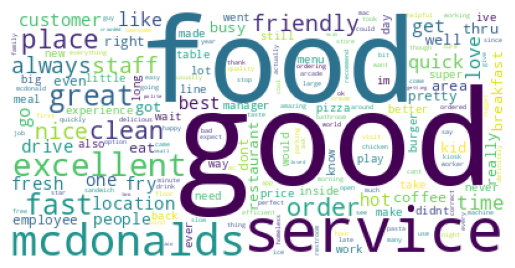

In [ ]:
cloud = WordCloud(background_color="white", colormap="viridis")
pos_cloud = cloud.generate_from_frequencies(counts_pos_dict)
plt.axis("off")
plt.imshow(pos_cloud)
plt.show()

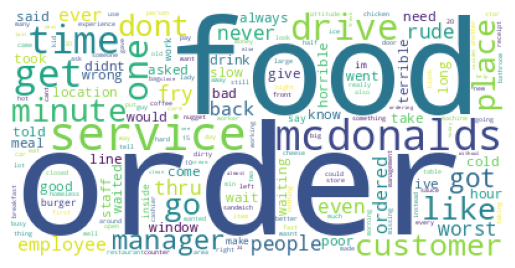

In [ ]:
cloud = WordCloud(background_color="white", colormap="viridis")
neg_cloud = cloud.generate_from_frequencies(counts_neg_dict)
plt.axis("off")
plt.imshow(neg_cloud)
plt.show()

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X = cleaned_mcd_reviews['cleaned_text']
y = cleaned_mcd_reviews['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)  # vocabulary

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(22862, 5000)
(5716, 5000)


## Naive Bayes Classifier

In [ ]:
# Initialize Multinomial Naive Bayes
nb = MultinomialNB()

# Train the model
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# predictions
y_pred = nb.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

Accuracy: 0.9029041287613716

Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.90      0.89      2494
    positive       0.92      0.91      0.91      3222

    accuracy                           0.90      5716
   macro avg       0.90      0.90      0.90      5716
weighted avg       0.90      0.90      0.90      5716


Confusion Matrix:
 [[2241  253]
 [ 302 2920]]


---

# *Part I. Class Stuff

Understanding what's happening based on information from lectures.

## TF-IDF Understanding

In [ ]:
""" 1. Get the 5th batch in the training set. """

doc_index = 5

sample_sentence = X_train.iloc[doc_index]
sample_label = y_train.iloc[doc_index]

print("Sample Sentence: ", sample_sentence)
print("Label: ", sample_label)

""" 2. Get the TF-IDF for the 5th match.
      doc_tfidf: An array of 5000 values.
"""

doc_tfidf = X_train_tfidf[doc_index].toarray().flatten()

""" 3.
      words:  Array of our 5000 words.
      word_tfidf_mapping: maps the word to its TF-IDF value
"""

words = tfidf.get_feature_names_out()
word_tfidf_mapping = dict(zip(words, doc_tfidf))

""" 4. Sort by our TF-IDF values for the given test case.
      item[1] is the TF-IDF value.
      item[0] is our word.
"""

sorted_tfidf = sorted(word_tfidf_mapping.items(), key=lambda item: item[1], reverse=True)
for word, tfidf_value in sorted_tfidf[:10]:
    print(f"{word}: {tfidf_value:.4f}")

Sample Sentence:  service bit slow well mcdonalds playground nice kid though
Label:  positive
playground: 0.4892
bit: 0.4033
though: 0.3683
kid: 0.3312
well: 0.3235
slow: 0.3059
nice: 0.2820
mcdonalds: 0.2007
service: 0.1862
05: 0.0000


## Prior Probabilities

In [ ]:
""" Prior Probabilities """
class_log_prior = nb.class_log_prior_
class_probs = np.exp(class_log_prior)
print("\nClass Probabilities (P(class)):")
for idx, prob in enumerate(class_probs):
    print(f"Class {idx}: {prob:.4f}")


Class Probabilities (P(class)):
Class 0: 0.4384
Class 1: 0.5616


## Conditional Probabilities

In [ ]:
""" Conditional Probabilities

    Likelihood of a word showing up in a given class.

    feature_log_prob_: a 2-d array [[probabilities of "feature" in negative class], [probabilities of "feature" in positive class]]
    word_likelihoods: feature_log_prob but converted into probabilities
    word_likelihoods_dict = {
        Class 0: {'word1': probability_of_class_0, 'word2': probability_of_class_0, ...},
        Class 1: {'word1': probability_of_class_1, 'word2': probability_of_class_1, ...}
    }
"""

feature_log_prob = nb.feature_log_prob_
word_likelihoods = np.exp(feature_log_prob)   # probability of it showing up in document
word_likelihoods_dict = {
    f"Class {idx}": dict(zip(words, word_likelihoods[idx]))
    for idx in range(len(word_likelihoods))
}

print("\nConditional Probabilities (P(word | class)):")
target_words = ["service", "bit", "slow", "well", "mcdonalds", "playground", "nice", "kid", "though"]
for class_label, likelihoods in word_likelihoods_dict.items():
    print(f"\n{class_label}:")

    # Only display conditional probabilities for target words
    for word in target_words:
        if word in likelihoods:
            print(f"{word}: {likelihoods[word]:.4f}")
        else:
            print(f"{word}: Not found in vocabulary")


Conditional Probabilities (P(word | class)):

Class 0:
service: 0.0088
bit: 0.0004
slow: 0.0056
well: 0.0010
mcdonalds: 0.0066
playground: 0.0001
nice: 0.0007
kid: 0.0011
though: 0.0008

Class 1:
service: 0.0191
bit: 0.0011
slow: 0.0012
well: 0.0027
mcdonalds: 0.0118
playground: 0.0005
nice: 0.0098
kid: 0.0028
though: 0.0011


## Posterior Probabilities

In [ ]:
""" Creating a DataFrame for clarity """
flat_data = []
for class_label, likelihoods in word_likelihoods_dict.items():
    for word, likelihood in likelihoods.items():
        flat_data.append([class_label, word, likelihood])

words_likelihoods_df = pd.DataFrame(flat_data, columns=["Class", "Word", "Likelihood"])


""" Posterior Log Probability using TF-IDF

    How to Read:
    log_probs =
      [Prior(Positive) , Prior(Negative)] +

      ([Probability of "feature" in Positive Class, Probability of "feature" in Negative Class]
        *[TF_IDF of "feature"]).sum()
"""

log_probs = class_log_prior + (feature_log_prob * doc_tfidf).sum(axis=1)

# print(f'\nPrior Log Probabilities: {class_log_prior}')
# print(f'TF-IDF Log Probabilities: {(feature_log_prob * doc_tfidf).sum(axis=1)}')
print(f'Posterior Log Probabilities: {log_probs}')

Posterior Log Probabilities: [-21.15522036 -18.45939814]


## Normalization

In [ ]:
""" Softmax Normalization """
posterior_probs = np.exp(log_probs - np.max(log_probs))  # Stability adjustment
posterior_probs /= posterior_probs.sum()


print("\nPosterior Probabilities for the Document:")
for idx, prob in enumerate(posterior_probs):
    print(f"Class {idx}: {prob:.4f}")


Posterior Probabilities for the Document:
Class 0: 0.0632
Class 1: 0.9368


## Calculating it Manually

In [ ]:
import numpy as np
import math


tf_idf_weights = {
    'playground': 0.4892,
    'bit': 0.4033,
    'though': 0.3683,
    'kid': 0.3312,
    'well': 0.3235,
    'slow': 0.3059,
    'nice': 0.2820,
    'mcdonalds': 0.2007,
    'service': 0.1862,
    '05': 0.0000
}

document_words = ["service", "bit", "slow", "well", "mcdonalds", "playground", "nice", "kid", "though"]

# Prior Probabilities (log scale from Naive Bayes)
prior_probabilities = np.array([0.4384, 0.5616])  # Class 0 (negative), Class 1 (positive)

# Conditional Probabilities (likelihood for each word in each class)
conditional_probabilities_pos = {
    'service': 0.0088,
    'bit': 0.0004,
    'slow': 0.0056,
    'well': 0.0010,
    'mcdonalds': 0.0066,
    'playground': 0.0001,
    'nice': 0.0007,
    'kid': 0.0011,
    'though': 0.0008
}

conditional_probabilities_neg = {
    'service': 0.0191,
    'bit': 0.0011,
    'slow': 0.0012,
    'well': 0.0027,
    'mcdonalds': 0.0118,
    'playground': 0.0005,
    'nice': 0.0098,
    'kid': 0.0028,
    'though': 0.0011
}

# Step 1: Calculate the likelihood for the document for both positive and negative classes
log_prob_pos = np.log(prior_probabilities[1])  # Start with the log of the prior for class 1 (positive)
log_prob_neg = np.log(prior_probabilities[0])  # Start with the log of the prior for class 0 (negative)

# Step 2: Multiply TF-IDF scores by conditional probabilities for each word in the document
for word in document_words:
    if word in tf_idf_weights:
        tfidf_score = tf_idf_weights[word]
        # Update the log probabilities by multiplying with the word's likelihood and TF-IDF weight
        if word in conditional_probabilities_pos:
            log_prob_pos += np.log(conditional_probabilities_pos[word]) * tfidf_score
        if word in conditional_probabilities_neg:
            log_prob_neg += np.log(conditional_probabilities_neg[word]) * tfidf_score


# Step 3: Calculate the posterior probabilities
log_probs = np.array([log_prob_pos, log_prob_neg])
print(log_probs)

exp_probs = np.exp(log_probs)  # Convert to probabilities
posterior_probs = exp_probs / np.sum(exp_probs)  # Normalize to get posterior probabilities

# Output the posterior probabilities
print("Posterior Probabilities for the Document:")
print(f"Positive Sentiment: {posterior_probs[1]:.4f}")
print(f"Negative Sentiment: {posterior_probs[0]:.4f}")

[-20.87894661 -18.64934445]
Posterior Probabilities for the Document:
Positive Sentiment: 0.9029
Negative Sentiment: 0.0971


## Test Cases

In [ ]:
# test cases
test_cases = [
   ['very good service and we enjoyed all our food'],
   ['awful service']
]

# feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

for test_case in test_cases:
    # transform the test case to TF-IDF
    test_case_tfidf = tfidf.transform(test_case)

    predicted_probabilities = nb.predict_proba(test_case_tfidf)
    predicted_sentiment = nb.predict(test_case_tfidf)[0]

    print(f"Test Case: {test_case[0]}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Predicted Probabilities: {predicted_probabilities[0]}")
    print()

Test Case: very good service and we enjoyed all our food
Predicted Sentiment: positive
Predicted Probabilities: [0.01588975 0.98411025]

Test Case: awful service
Predicted Sentiment: negative
Predicted Probabilities: [0.89814013 0.10185987]



## Saving the Model

In [ ]:
import joblib
joblib.dump(nb, 'mcdonalds_sentiment_model.pkl')

['mcdonalds_sentiment_model.pkl']

---

---

# Part II. Using the Model

Use Naive Bayes Classifier to build a “score” for every individual McDonald's listed in the dataset.

In [ ]:
import pandas as pd

In [ ]:
mcd_reviews = pd.read_csv('mcdonalds_reviews.csv',encoding='ISO-8859-1')
mcd_reviews2 = mcd_reviews.copy()
mcd_reviews2 = mcd_reviews2[['store_address','review','rating']]

# focusing on 1, 2, 4, and 5 star reviews
mcd_reviews2 = mcd_reviews2[
    (mcd_reviews2['rating'] == '1 star') |
    (mcd_reviews2['rating'] == '2 stars') |
    (mcd_reviews2['rating'] == '4 stars') |
    (mcd_reviews2['rating'] == '5 stars')
]

mcd_reviews2.replace({'5 stars': 'positive', '1 star': 'negative',
                              '2 stars': 'negative', '4 stars': 'positive'}, inplace=True)

mcd_reviews2.columns = ['address', 'text', 'sentiment']

In [ ]:
mcd_reviews2['cleaned_text'] = (
    mcd_reviews2['text']
    .str.lower()
    .str.replace(f"[{string.punctuation}]", "", regex=True)
    .apply(preprocess_text)
)

mcd_reviews2.drop(columns=['text'],inplace=True)

In [ ]:
mcd_reviews2.head()
mcd_reviews2.shape

(28578, 3)

In [ ]:
# getting the individual states
mcd_reviews2['state'] = (
    mcd_reviews2['address']
    .str.split(',')
    .str[-2]
    .str.split(' ')
    .str[-2]
    .str.strip()
)

In [ ]:
reviews_by_state = (
    mcd_reviews2
    .groupby('state')
    .agg({'sentiment': 'value_counts'})
    .rename(columns={'sentiment': 'count'})
)

In [ ]:
reviews_by_state

count
state sentiment       
CA    positive    2776
      negative    2006
DC    positive     410
      negative     151
FL    negative    4015
      positive    3637
IL    positive     398
      negative     222
NJ    positive    1149
      negative     767
NV    positive     442
      negative     434
NY    positive    2685
      negative    1623
PA    positive     572
      negative     265
TX    positive    2972
      negative    2227
UT    negative     484
      positive     280
VA    positive     384
      negative     131

<Axes: xlabel='state', ylabel='count'>

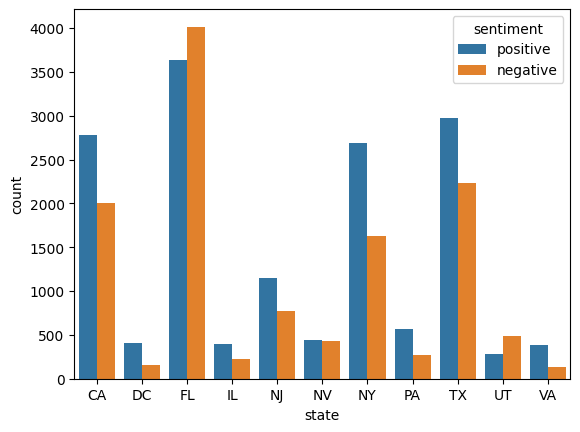

In [ ]:
import seaborn as sns
sns.barplot(data=reviews_by_state.reset_index(), x='state', y='count', hue='sentiment')

In [ ]:
import joblib

nb = joblib.load('mcdonalds_sentiment_model.pkl')

mcd_reviews2['sentiment_score'] = (
    mcd_reviews2
    .cleaned_text
    .apply(lambda x: tfidf.transform([x]))
    .apply(lambda x: nb.predict_proba(x))       # this gets the probabilities ['negative','positive']
    .apply(lambda x: x[0][1])                   # extract the probability of the positive class (index 1)
)# .drop(columns=['address'], inplace=True)

In [ ]:
mcd_reviews2.head()

,address,sentiment,cleaned_text,state,sentiment_score
0,"13749 US-183 Hwy, Austin, TX 78750, United States",negative,look like someone spit food normal transaction...,TX,0.307501
1,"13749 US-183 Hwy, Austin, TX 78750, United States",positive,itd mcdonalds far food atmosphere go staff mak...,TX,0.957037
2,"13749 US-183 Hwy, Austin, TX 78750, United States",negative,made mobile order got speaker checked line mov...,TX,0.020114
3,"13749 US-183 Hwy, Austin, TX 78750, United States",positive,mc crispy chicken sandwich customer service qu...,TX,0.752485
4,"13749 US-183 Hwy, Austin, TX 78750, United States",negative,repeat order 3 time drive thru still manage me...,TX,0.068566


# Part III. Exploratory Data Analysis

Exploratory Data Analysis to see which region or area should improve their McDonald's.

In [ ]:
# mcd_reviews2.isnull().sum()

# i found out that hawaii is the null state
mcd_reviews2['state'].replace({None: 'HI'}, inplace=True)

<ipython-input-137-baa9d5cd687a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mcd_reviews2['state'].replace({None: 'HI'}, inplace=True)


In [ ]:
mcd_reviews2['address'].unique()

array(['13749 US-183 Hwy, Austin, TX 78750, United States',
       '1698 US-209, Brodheadsville, PA 18322, United States',
       '72-69 Kissena Blvd, Queens, NY 11367, United States',
       '429 7th Ave, New York, NY 10001, United States',
       '724 Broadway, New York, NY 10003, United States',
       '160 Broadway, New York, NY 10038, United States',
       '555 13th St NW, Washington, DC 20004, United States',
       '10451 Santa Monica Blvd, Los Angeles, CA 90025, United States',
       '114 Delancey St, New York, NY 10002, United States',
       '5920 Balboa Ave, San Diego, CA 92111, United States',
       '262 Canal St, New York, NY 10013, United States',
       '490 8th Ave, New York, NY 10001, United States',
       '550 Lawrence Expy, Sunnyvale, CA 94086, United States',
       '11382 US-441, Orlando, FL 32837, United States',
       '210 5th S, Salt Lake City, UT 84106, United States',
       '1916 M St NW, Washington, DC 20036, United States',
       "151 West 34th Street

In [ ]:
average_sentiment_by_state = (
    mcd_reviews2
    .groupby('state')
    .agg({'sentiment_score': 'mean'})
)

In [ ]:
(
   mcd_reviews2[mcd_reviews2['state'] == 'UT']
)

,address,sentiment,cleaned_text,state,sentiment_score
8460,"210 5th S, Salt Lake City, UT 84106, United St...",negative,quick stop bite tide u couple kid u went thru ...,UT,0.023482
8461,"210 5th S, Salt Lake City, UT 84106, United St...",negative,lobby absolutely disgusting trash food floor s...,UT,0.025849
8462,"210 5th S, Salt Lake City, UT 84106, United St...",negative,store filthy employee using profanity back cus...,UT,0.026661
8463,"210 5th S, Salt Lake City, UT 84106, United St...",positive,doordashing time would never eat mcdonalds im ...,UT,0.235855
8464,"210 5th S, Salt Lake City, UT 84106, United St...",negative,went pick mobile order 345am option go drive t...,UT,0.010993
...,...,...,...,...,...
9345,"210 5th S, Salt Lake City, UT 84106, United St...",negative,chicken mc nugget tasted sitting awhile,UT,0.347444
9346,"210 5th S, Salt Lake City, UT 84106, United St...",positive,sausage burrito 1 best breakfast deal town,UT,0.901483
9347,"210 5th S, Salt Lake City, UT 84106, United St...",negative,never get order right take along time get food,UT,0.295506
9348,"210 5th S, Salt Lake City, UT 84106, United St...",negative,got harassed security guard minute pulled made...,UT,0.063327


<Axes: xlabel='state', ylabel='sentiment_score'>

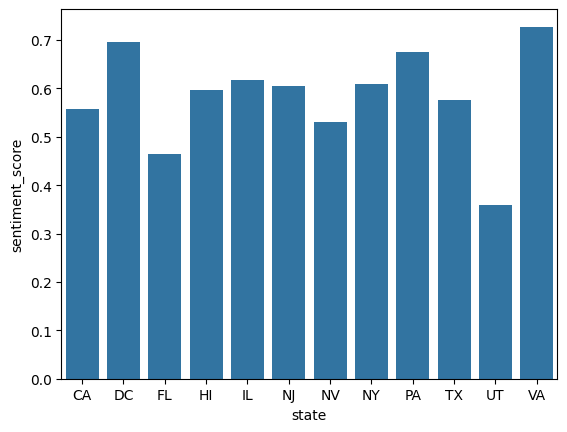

In [ ]:
sns.barplot(data=average_sentiment_by_state.reset_index(), x='state', y='sentiment_score')

In [ ]:
# cool stuff lol